In [159]:
# -*- coding: utf8 -*-
from __future__ import print_function
import codecs,glob
import features
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import networkx as nx
import pickle
from math import *
debug=False

In [160]:
echantillonNumeros=["00"]
phonologicalMap="-X"
casesType="-X-Morphomes"
casesType="-X"

In [161]:
filePrefix="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/Longitudinales/"
sampleFiles=glob.glob(filePrefix+"Longitudinal*Regles.pkl")

In [162]:
features.add_config('../bdlexique.ini')
fs=features.FeatureSystem('phonemes')
validPhonemes=list(fs.supremum.concept.extent)

In [163]:
neutralisationsNORD=(u"6û",u"9ê")
neutralisationsSUD=(u"e2o",u"E9O")
if phonologicalMap=="-N":
    neutralisations=neutralisationsNORD
elif phonologicalMap=="-S":
    neutralisations=neutralisationsSUD
else:
    neutralisations=(u"",u"")
    phonologicalMap=("-X")
bdlexiqueIn = unicode(u"èò"+neutralisations[0])
bdlexiqueNum = [ord(char) for char in bdlexiqueIn]
neutreOut = unicode(u"EO"+neutralisations[1])
neutralise = dict(zip(bdlexiqueNum, neutreOut))

In [164]:
def recoder(chaine,table=neutralise):
    if type(chaine)==str:
        temp=unicode(chaine.decode('utf8')).translate(table)
        result=temp.encode('utf8')
    elif type(chaine)==unicode:
        result=chaine.translate(table)
    else:
        result=chaine
    return result

In [165]:
dierese={"j":"ij", "w":"uw","H":"yH","i":"ij","u":"uw","y":"yH"}

In [166]:
def checkFrench(prononciation):
    if prononciation:
        result=recoder(prononciation)
        m=re.match(ur"^.*([^ieèEaOouy926êôâ])[jwH]$",result)
        if m:
            print ("pb avec un glide final", prononciation)
        m=re.match(ur"(.*[ptkbdgfsSvzZ][rl])([jwH])(.*)",result)
        if m:
            n=re.search(ur"[ptkbdgfsSvzZ][rl](wa|Hi|wê)",result)
            if not n:
                glide=m.group(2)
                result=m.group(1)+dierese[glide]+m.group(3)
        m=re.match(ur"(.*)([iuy])([ieEaOouy].*)",result)
        if m:
            glide=m.group(2)
            result=m.group(1)+dierese[glide]+m.group(3)
    else:
        result=prononciation
    return result

In [167]:
def remplacementSortie(sortie):
    n=1
    nsortie=""
    for lettre in sortie:
        if lettre==".":
            nsortie+="\g<%d>"%n
            n+=1
        else:
            nsortie+=lettre
    return nsortie

In [168]:
class formesPatron:
    '''
    Accumulateur de formes correspondant à un patron pour calcul de la Généralisation Minimale (cf. MGL)
    '''
    def __init__(self):
        self.formes=[]

#    def __repr__(self):
#        return ','.join(self.calculerGM())
        
    def ajouterForme(self,forme):
        self.formes.append(forme)
        
    def calculerGM(self):
        minLongueur=len(min(self.formes, key=len))
        maxLongueur=len(max(self.formes, key=len))
        if debug: print (minLongueur, maxLongueur, file=logfile)
        positions=[]
        if maxLongueur>minLongueur:
            positions.append("*")
        for i in xrange(minLongueur, 0, -1):
            phonemes=set([x[-i] for x in self.formes])
            if debug: print (phonemes, file=logfile)
            if "." in phonemes:
                positions.append(".")
            else:
                positions.append("".join(fs.lattice[phonemes].extent))
        return patron2regexp(positions)

class pairePatrons:
    '''
    Accumulateur de triplets (f1,f2,patron) correspondant à une paire pour calcul des Généralisations Minimales (cf. MGL)
    '''
    def __init__(self,case1,case2):
        self.patrons1={}
        self.patrons2={}
        self.case1=case1
        self.case2=case2

#    def __repr__(self):
#        return ','.join(self.calculerGM())
        
    def ajouterFormes(self,forme1,forme2,patron):
#        print (forme1,forme2,patron, file=logfile)
        patron12=patron
        (pat1,pat2)=patron.split("-")
        patron21=pat2+"-"+pat1
#        print (patron12,patron21, file=logfile)
        if not patron12 in self.patrons1:
            self.patrons1[patron12]=formesPatron()
        self.patrons1[patron12].ajouterForme(forme1)
        if not patron21 in self.patrons2:
            self.patrons2[patron21]=formesPatron()
        self.patrons2[patron21].ajouterForme(forme2)
        
        
    def calculerGM(self):
        resultat1={}
        for patron in self.patrons1:
            if debug: print ("patron1", patron, file=logfile)
            resultat1[patron]=self.patrons1[patron].calculerGM()
        resultat2={}
        for patron in self.patrons2:
            if debug: print ("patron2", patron, file=logfile)
            resultat2[patron]=self.patrons2[patron].calculerGM()
        return (resultat1,resultat2) 

In [169]:
class paireClasses:
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classes1=classesPaire(case1,case2)
        self.classes2=classesPaire(case2,case1)

    def ajouterPatron(self,n,patron,motif):
        if n==1:
            self.classes1.ajouterPatron(patron,motif)
        elif n==2:
            self.classes2.ajouterPatron(patron,motif)
        else:
            if debug: print ("le numéro de forme n'est pas dans [1,2]",n, file=logfile)

    def ajouterPaire(self,forme1,forme2):
        self.classes1.ajouterPaire(forme1,forme2)
        self.classes2.ajouterPaire(forme2,forme1)
        
    def calculerClasses(self):
        return(self.classes1,self.classes2)

    
class classesPaire:
    '''
    Gestion des patrons, des classes et des transformations
    
    ajouterPatron : ajoute un patron et son motif associé (MGL)
    ajouterPaire : ajoute une paire de formes, calcule la classe de la forme1 et la règle sélectionnée
    sortirForme : cacule les formes de sortie correspondant à la forme1 avec leurs coefficients respectifs
    '''
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classe={}
        self.nbClasse={}
        self.patrons={}
        self.entree={}
        self.sortie={}
        self.classeCF={}
        self.nbClasseCF={}
    
    def ajouterPatron(self,patron,motif):
        self.patrons[patron]=motif
        (entree,sortie)=patron.split("-")
        self.entree[patron]=entree.replace(u".",u"(.)")
        self.sortie[patron]=remplacementSortie(sortie)
    
    def ajouterPaire(self,forme1,forme2):
        '''
        on calcule la classe de la paire idClasseForme et la règle sélectionnée
        on incrémente le compteur de la classe et celui de la règle sélectionnée à l'intérieur de la classe
        '''
        classeFormeCF=[]
        regleFormeCF=""
        classeForme=[]
        regleForme=""
        for patron in self.patrons:
            filterF1=".*"+patron.split("-")[0]+"$"
            if re.match(filterF1,forme1):
                classeFormeCF.append(patron)
                if forme2==re.sub(self.entree[patron]+"$",self.sortie[patron],forme1):
                    regleFormeCF=patron
            filterF1=self.patrons[patron]
            if re.match(filterF1,forme1):
                classeForme.append(patron)
                '''
                le +"$" permet de forcer l'alignement à droite pour les transformations suffixales
                '''
                if forme2==re.sub(self.entree[patron]+"$",self.sortie[patron],forme1):
                    regleForme=patron
        idClasseFormeCF=", ".join(classeFormeCF)
        if not idClasseFormeCF in self.classeCF:
            self.classeCF[idClasseFormeCF]={}
            self.nbClasseCF[idClasseFormeCF]=0
        if not regleFormeCF in self.classeCF[idClasseFormeCF]:
            self.classeCF[idClasseFormeCF][regleFormeCF]=0
        self.nbClasseCF[idClasseFormeCF]+=1
        self.classeCF[idClasseFormeCF][regleFormeCF]+=1
        
        idClasseForme=", ".join(classeForme)
        if not idClasseForme in self.classe:
            self.classe[idClasseForme]={}
            self.nbClasse[idClasseForme]=0
        if not regleForme in self.classe[idClasseForme]:
            self.classe[idClasseForme][regleForme]=0
        self.nbClasse[idClasseForme]+=1
        self.classe[idClasseForme][regleForme]+=1

    def sortirForme(self,forme,contextFree=False):
        classeForme=[]
        sortieForme={}
        for patron in self.patrons:
            if contextFree:
                filterF1=".*"+patron.split("-")[0]+"$"
            else:
                filterF1=self.patrons[patron]
            if re.match(filterF1,forme):
                classeForme.append(patron)
        if classeForme:
            idClasseForme=", ".join(classeForme)
            if contextFree:
                nbClasse=self.nbClasseCF
                classe=self.classeCF
            else:
                nbClasse=self.nbClasse
                classe=self.classe
            if idClasseForme in nbClasse:
                nTotal=nbClasse[idClasseForme]
                for patron in classe[idClasseForme]:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(classe[idClasseForme][patron])/nTotal
            else:
                if debug: 
                    print (forme, file=logfile)
                    print ("pas de classe",idClasseForme, file=logfile)
                    print ("%.2f par forme de sortie" % (float(1)/len(classeForme)), file=logfile)
                nTotal=len(classeForme)
                for patron in classeForme:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(1)/nTotal
        else:
            if debug:
                print (forme, file=logfile) 
                print ("pas de patron", file=logfile)
        return sortieForme
        

In [170]:
def lireRegles(nomRegles):
    with open(nomRegles, 'rb') as input:
        regles=pickle.load(input)
    return regles

In [171]:
def nomEchantillon(numero,casesType="-X"):
    candidats=set()
    for sample in sampleFiles:
        m=re.match(ur"^.*/(Longitudinal-%s-T\d+-F\d+)%s-Regles\.pkl"%(numero,casesType),sample)
        if m:
            candidats.add(sample)
    if len(candidats)==1:
        return list(candidats)[0]
    else:
        print ("PB pas de nom unique correspondant",candidats)

In [201]:
nomRegles=nomEchantillon("129","-X-Morphomes")
regles=lireRegles(nomRegles)

In [202]:
def classeUnique(classe,debug=False):
    if debug: print (classe)
    unique=True
    for  c in classe:
        nbOut=0
        for e in classe[c]:
            if classe[c][e]!=0:
                nbOut+=1
        if nbOut!=1:
            unique=False
            break
    return unique

In [203]:
classeUnique(regles[("fi1S","ps1P")].classe,True)

{u'6rE-asj\xf4': {u'6rE-asj\xf4': 1}, u'6rE-j\xf4': {u'6rE-j\xf4': 21}, u'drE-lj\xf4': {u'drE-lj\xf4': 1}, u'OrE-Ej\xf4': {u'OrE-Ej\xf4': 1}, u'urE-Hisj\xf4': {u'urE-Hisj\xf4': 1}, u'rE-j\xf4': {u'rE-j\xf4': 4}, u'rE-j\xf4, j\xeadrE-6nj\xf4': {u'j\xeadrE-6nj\xf4': 1}, u'6rE-waj\xf4': {u'6rE-waj\xf4': 1}, u'OrE-aSj\xf4': {u'OrE-aSj\xf4': 1}, u'irE-j\xf4': {u'irE-j\xf4': 1}}


True

# Espaces thématiques

- Les paires de cases ayant une seule règle associée sont reliées
- Les paires avec une entropie de 0 sont reliées

In [204]:
def findClique(cliques,remElement="node"):
    pNodes=set()

    sCliques=sorted(cliques, key=len, reverse=True)

    cliqueFound=sorted(sCliques[0])
    pNodes=pNodes|set(sCliques[0])

    if remElement=="clique":
        removeCliques=[]
        for clique in sCliques:
            sClique=set(clique)
            if set.intersection(pNodes,sClique):
                removeCliques.append(clique)
        for clique in removeCliques:
            sCliques.remove(clique)
    elif remElement=="node":
        newCliques=[]
        for clique in sCliques:
            sClique=set(clique)
            diffClique=list(sClique-set.intersection(pNodes,sClique))
            if diffClique:
                newCliques.append(diffClique)               
#            print "sortie",newCliques
        sCliques=sorted(newCliques,key=len,reverse=True)
    else:
        print ("remElement non prévu")
    return (cliqueFound,sCliques)

In [205]:
circulationSS=nx.DiGraph()
circulationNE=nx.DiGraph()
for (cellIn,cellOut) in regles:
    if len(regles[(cellIn,cellOut)].patrons)==1:
        circulationSS.add_edge(cellIn,cellOut)
    if classeUnique(regles[(cellIn,cellOut)].classe):
        circulationNE.add_edge(cellIn,cellOut)

In [206]:
espaceSS=nx.Graph()
for (cellIn,cellOut) in circulationSS.edges():
    if (cellOut,cellIn) in circulationSS.edges():
        espaceSS.add_edge(cellIn,cellOut)
#espace.edges()
cliquesSS=list(nx.find_cliques(espaceSS))
sCliquesSS=sorted(cliquesSS, key=len, reverse=True)
foundCliquesSS=[]
while sCliquesSS:
    foundCliqueSS,sCliquesSS=findClique(sCliquesSS)
    foundCliquesSS.append(foundCliqueSS)
foundCliquesSS

[[u'ai1P', u'ai2P', u'ai2S', u'is1P', u'is1S', u'is2P'],
 [u'ps1P', u'ps2P'],
 [u'ai1S', u'ai3P'],
 [u'ii1P'],
 [u'pP'],
 [u'ppFP'],
 [u'pc1P'],
 [u'pI1P'],
 [u'ppMP'],
 [u'ii2P'],
 [u'inf']]

In [214]:
espaceNE=nx.Graph()
for (cellIn,cellOut) in circulationNE.edges():
    if (cellOut,cellIn) in circulationNE.edges():
        espaceNE.add_edge(cellIn,cellOut)
#espace.edges()
cliquesNE=list(nx.find_cliques(espaceNE))
sCliquesNE=sorted(cliquesNE, key=len, reverse=True)
foundCliquesNE=[]
while sCliquesNE:
    foundCliqueNE,sCliquesNE=findClique(sCliquesNE)
    foundCliquesNE.append(foundCliqueNE)
foundCliquesNE

[[u'ai1P', u'ai1S', u'ai2P', u'ai2S', u'ai3P', u'is1P', u'is1S', u'is2P'],
 [u'ii1P', u'ii2P', u'ps1P', u'ps2P'],
 [u'pI1P', u'pP'],
 [u'pc1P'],
 [u'ii1S'],
 [u'pi1P'],
 [u'pi2P'],
 [u'inf'],
 [u'pc3P'],
 [u'pi3P'],
 [u'pi2S'],
 [u'fi1P'],
 [u'pc2P'],
 [u'fi1S'],
 [u'pi1S'],
 [u'pi3S'],
 [u'pI2S'],
 [u'fi2P'],
 [u'fi2S'],
 [u'ps1S'],
 [u'ppMP'],
 [u'ppFP'],
 [u'pI2P']]

In [207]:
#https://stackoverflow.com/questions/9213797/graphviz-drawing-maximal-cliques

def draw_circle_around_clique(clique,coords):
    dist=0
    temp_dist=0
    center=[0 for i in range(2)]
    color=colors.next()
    for a in clique:
        for b in clique:
            temp_dist=(coords[a][0]-coords[b][0])**2+(coords[a][1]-coords[b][1])**2
            if temp_dist>dist:
                dist=temp_dist
                for i in range(2):
                    center[i]=(coords[a][i]+coords[b][i])/2
    rad=dist**0.5/2
    cir = plt.Circle((center[0],center[1]),   radius=rad*1.3,fill=False,color=color,hatch=hatches.next())
    plt.gca().add_patch(cir)
    plt.axis('scaled')
    # return color of the circle, to use it as the color for vertices of the cliques
    return color

global colors, hatches
#colors=it.cycle('bgrcmyk')# blue, green, red, ...
colors=it.cycle('bgcmyk')# blue, green, red, ...
hatches=it.cycle('/\|-+*')


Clique to appear:  [u'ai1P', u'ai2P', u'ai2S', u'is1P', u'is1S', u'is2P']
Clique to appear:  [u'ps1P', u'ps2P']
Clique to appear:  [u'ai1S', u'ai3P']


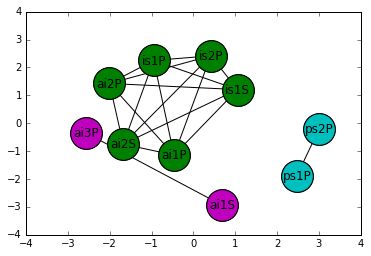

In [222]:
E=espaceSS
# remove "len(clique)>2" if you're interested in maxcliques with 2 edges
cliques=[clique for clique in foundCliquesSS if len(clique)>1]
nodes=[n for clique in cliques for n in clique]

G=E.subgraph(nodes)
coords=nx.shell_layout(G,scale=500)
coords=nx.spring_layout(G,pos=coords,k=3000,scale=3)
#print (coords)
#nx.rescale_layout(coords,scale=3)

#draw the graph
nx.draw_networkx(G,pos=coords,node_size=1000)
#labels={n:n for n in list(G.nodes)}
#nx.draw_networkx_labels(G,coords,labels,font_size=10)
for clique in cliques:
    print ("Clique to appear: ",clique)
#    nx.draw_networkx_nodes(G,pos=coords,nodelist=clique,node_color=draw_circle_around_clique(clique,coords))
    nx.draw_networkx_nodes(G,pos=coords,nodelist=clique,node_size=1000,node_color=colors.next())
plt.show()

Clique to appear:  [u'ai1P', u'ai1S', u'ai2P', u'ai2S', u'ai3P', u'is1P', u'is1S', u'is2P']
Clique to appear:  [u'ii1P', u'ii2P', u'ps1P', u'ps2P']
Clique to appear:  [u'pI1P', u'pP']


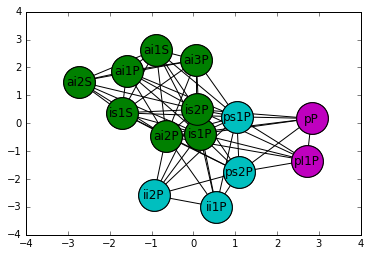

In [226]:
E=espaceNE
# remove "len(clique)>2" if you're interested in maxcliques with 2 edges
cliques=[clique for clique in foundCliquesNE if len(clique)>1]
nodes=[n for clique in cliques for n in clique]

G=E.subgraph(nodes)
coords=nx.shell_layout(G,scale=10000)
coords=nx.spring_layout(G,pos=coords,k=5000,scale=3)
#print (coords)
#nx.rescale_layout(coords,scale=3)

#draw the graph
nx.draw_networkx(G,pos=coords,node_size=1000)
#labels={n:n for n in list(G.nodes)}
#nx.draw_networkx_labels(G,coords,labels,font_size=10)
for clique in cliques:
    print ("Clique to appear: ",clique)
#    nx.draw_networkx_nodes(G,pos=coords,nodelist=clique,node_color=draw_circle_around_clique(clique,coords))
    nx.draw_networkx_nodes(G,pos=coords,nodelist=clique,node_size=1000,node_color=colors.next())
plt.show()

In [196]:
G.edges()

EdgeView([(u'is1S', u'ai3S'), (u'is1S', u'is2S'), (u'is1S', u'is2P'), (u'is1S', u'is1S'), (u'is1S', u'is1P'), (u'is1S', u'ai2P'), (u'is1S', u'ai2S'), (u'is1S', u'is3P'), (u'is1S', u'is3S'), (u'is1S', u'ai1P'), (u'ii1S', u'ii2S'), (u'ii1S', u'ii1S'), (u'ii1S', u'ii3P'), (u'ai3S', u'ai3S'), (u'ai3S', u'is2S'), (u'ai3S', u'is2P'), (u'ai3S', u'is1P'), (u'ai3S', u'ai2P'), (u'ai3S', u'ai2S'), (u'ai3S', u'is3P'), (u'ai3S', u'is3S'), (u'ai3S', u'ai1P'), (u'is3P', u'ai2P'), (u'is3P', u'is2S'), (u'is3P', u'is2P'), (u'is3P', u'is1P'), (u'is3P', u'ai2S'), (u'is3P', u'is3P'), (u'is3P', u'is3S'), (u'is3P', u'ai1P'), (u'is3S', u'is2S'), (u'is3S', u'is2P'), (u'is3S', u'is1P'), (u'is3S', u'ai2P'), (u'is3S', u'ai2S'), (u'is3S', u'is3S'), (u'is3S', u'ai1P'), (u'ai1P', u'ai2P'), (u'ai1P', u'is2S'), (u'ai1P', u'is2P'), (u'ai1P', u'is1P'), (u'ai1P', u'ai2S'), (u'ai1P', u'ai1P'), (u'ii3P', u'ii2S'), (u'ii3P', u'ii3P'), (u'ps1P', u'ps1P'), (u'ps1P', u'ps2P'), (u'is2S', u'is2S'), (u'is2S', u'is2P'), (u'is2S', 